In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_30976\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. 

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

corners     = gpd.read_file(r"C:\Users\fhacesga\Downloads\Intersections_CoH.gpkg").to_crs("EPSG:3857")

In [4]:
base_dir = r"D:\CaseStudies_CoH_FineAdjustDigitization1\\"

corner_dir      = base_dir + "pkl\\"
manual_dir      = base_dir + "Manual\\"
coarse_tiles_dir= base_dir + "CoarseAdjustImages\\"
fine_tiles_dir  = base_dir + "FineAdjustImages\\"

match_files = glob.glob(manual_dir + "*.shp") + glob.glob(manual_dir + "*.gpkg")

In [5]:
match_files

['D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\4802960155B.shp',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\4802960175E.shp',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\48201C0855J.shp',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\48201C0865J.shp',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\4802960055B.gpkg',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\4802960060B.gpkg',
 'D:\\CaseStudies_CoH_FineAdjustDigitization1\\\\Manual\\48201C0860J.gpkg']

In [6]:
def getBBOX(im_file, RLNN):
    bounds, RLNN = findBounds(im_file, RLNN)

    image = np.asarray(cv2.imread(im_file))
    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {im_file}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
    return bbox, RLNN

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.05, filter_by_bounding_box=True):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    if len(corner_bbox) == 0:
        return None, None

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)

    if filter_by_bounding_box:
        bbox, _ = getBBOX(tile_dir, None)
        corner_arry, corner_confs = cleanCenterBBOX(corner_arry, bbox, opt_return=[corner_confs])

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    im_corner_gdf['im_x'] = corner_arry[:, 0]
    im_corner_gdf['im_y'] = corner_arry[:, 1]
    return im_corner_gdf, corner_confs

coarse_tiles = []
for tile_name in tqdm(match_files):
    tile = os.path.join(coarse_tiles_dir, os.path.basename(tile_name).split(".")[0] + ".tif")
    ra_ref = rio.open(tile)
    
    a, b = getTileCorners(tile, ra_ref, conf_thresh=0.05)
    a['confidence'] = b
    a['image'] = os.path.basename(tile_name).split(".")[0]
    a = a.set_crs("EPSG:3857")

    coarse_tiles.append(a)

fine_tiles = []
for tile_name in tqdm(match_files):
    tile = os.path.join(fine_tiles_dir, os.path.basename(tile_name).split(".")[0] + ".tif")
    ra_ref = rio.open(tile)
    
    a, b = getTileCorners(tile, ra_ref, conf_thresh=0.05)
    a['confidence'] = b
    a['image'] = os.path.basename(tile_name).split(".")[0]
    print(os.path.basename(tile_name).split(".")[0])
    a = a.set_crs("EPSG:3857")

    fine_tiles.append(a)    

  0%|          | 0/7 [00:00<?, ?it/s]

947 / 3386
637 / 1648
1587 / 5368
1356 / 4905
1007 / 3435
641 / 1946
2240 / 6160


  0%|          | 0/7 [00:00<?, ?it/s]

947 / 3386
4802960155B
637 / 1648
4802960175E
1587 / 5368
48201C0855J
1356 / 4905
48201C0865J
1007 / 3435
4802960055B
641 / 1946
4802960060B
2240 / 6160
48201C0860J


In [7]:
import shapely
from shapely.geometry import Point, LineString

def get_endpoint(linestring: LineString) -> Point:
    """
    Given a LineString with at least two points,
    return the second (endpoint) as a Shapely Point.
    """
    # convert coords to list so we can index
    pts = list(linestring.coords)
    if len(pts) < 2:
        raise ValueError("LineString must have at least two points")
    # pts[1] is the second coordinate
    return Point(pts[1])

val_tiles = []
for tile in tqdm(match_files):
    gdf = gpd.read_file(tile)
    gdf_new = gdf.explode(index_parts=False)
    if gdf_new.shape[0] != gdf.shape[0]:
        error
    coords = np.array([ls.coords[1] for ls in gdf_new.geometry.values])
    gdf["endpoint"] = [shapely.Point(x, y) for x, y in coords]
    # gdf['coord'] = gdf.geometry.apply(get_endpoint)
    val_tiles.append(gdf)

  0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
val_tiles[0]

,FID,MATCH,geometry,endpoint
0,0,1,"LINESTRING (-10630032.610 3457794.124, -106300...",POINT (-10630023.34314783 3457820.980469156)
1,1,0,"LINESTRING (-10619905.044 3461342.795, -106198...",POINT (-10619845.809430953 3461142.0406189146)
2,2,1,"LINESTRING (-10622936.620 3463919.260, -106229...",POINT (-10622913.876263853 3463937.9606296327)
3,3,1,"LINESTRING (-10625728.262 3456783.904, -106257...",POINT (-10625730.143508377 3456824.2696407177)
4,4,1,"LINESTRING (-10625822.683 3456783.762, -106258...",POINT (-10625829.507714944 3456824.0348706306)
...,...,...,...,...
898,898,1,"LINESTRING (-10628071.264 3460304.289, -106280...",POINT (-10628075.90600038 3460302.565603909)
899,899,0,"LINESTRING (-10624191.557 3457195.751, -106241...",POINT (-10624162.331550121 3457185.5780176003)
900,900,0,"LINESTRING (-10622798.692 3460866.999, -106226...",POINT (-10622638.694050072 3461485.4907492585)
901,901,0,"LINESTRING (-10622337.173 3459834.331, -106233...",POINT (-10623300.308858605 3459954.869819998)


In [9]:
for i in range(len(val_tiles)):
    print(fine_tiles[i].shape, coarse_tiles[i].shape, val_tiles[i].shape)

(903, 5) (903, 5) (903, 4)
(635, 5) (635, 5) (635, 4)
(1584, 5) (1584, 5) (1584, 4)
(1352, 5) (1352, 5) (1352, 4)
(999, 5) (999, 5) (999, 4)
(635, 5) (635, 5) (635, 4)
(2177, 5) (2177, 5) (2177, 4)


In [10]:
def getDistances(gdfa, gdfb):
    gdf = gpd.GeoDataFrame(geometry=gdfb).reset_index(drop=True)
    distances = gdfa.distance(gdf.geometry)
    return distances.reset_index(drop=True)

for i in range(len(fine_tiles)):
    fine_tiles[i] = fine_tiles[i].reset_index(drop=True)
    coarse_tiles[i] = coarse_tiles[i].reset_index(drop=True)
    fine_tiles[i]['distances']   = getDistances(fine_tiles[i].geometry, val_tiles[i].endpoint)
    coarse_tiles[i]['distances'] = getDistances(coarse_tiles[i].geometry, val_tiles[i].endpoint)

    coarse_tiles[i]['geometry'] = val_tiles[i]['geometry']
    fine_tiles[i]['geometry'] = val_tiles[i]['geometry']
    
    fine_tiles[i]['MATCH'] = val_tiles[i]['MATCH'].to_numpy()
    coarse_tiles[i]['MATCH'] = val_tiles[i]['MATCH'].to_numpy()

    if "48201" in match_files[i]:
        fine_tiles[i]['METHOD'] = 'CORNERCOORDINATES'
        coarse_tiles[i]['METHOD'] = 'CORNERCOORDINATES'
    else:
        fine_tiles[i]['METHOD'] = 'STREETREGISTRATION'
        coarse_tiles[i]['METHOD'] = 'STREETREGISTRATION'
    
    coarse_tiles[i]['STAGE'] = 'COARSE'
    fine_tiles[i]['STAGE'] = 'FINE'

In [11]:
myresults = pd.concat((pd.concat(coarse_tiles), pd.concat(fine_tiles))).reset_index(drop=True)

In [12]:
test = myresults[myresults['STAGE'] == 'FINE']
test = test[test['METHOD'] == 'STREETREGISTRATION']
print(test.shape)

(3172, 9)


In [13]:
myresults[myresults['MATCH'] == 1]['image'].unique()

array(['4802960155B', '4802960175E', '48201C0855J', '48201C0865J', '4802960055B', '4802960060B', '48201C0860J'], dtype=object)

In [14]:
import seaborn as sns

<Axes: xlabel='distances', ylabel='image'>

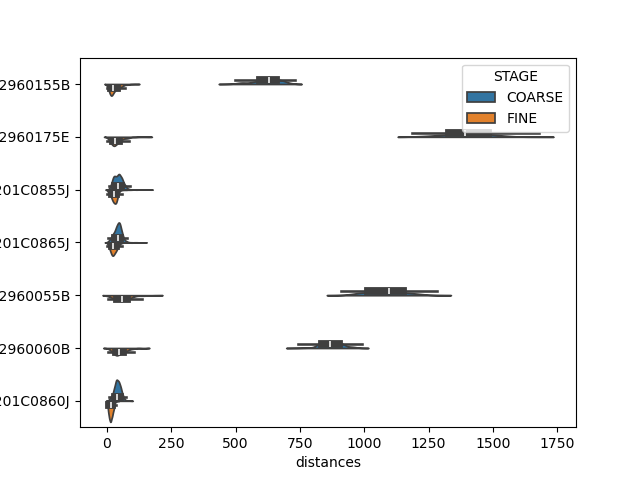

In [15]:
plt.figure()
sns.violinplot(x='distances', y='image', hue='STAGE', split=True, data=myresults[myresults['MATCH'] == 1], inner='box')


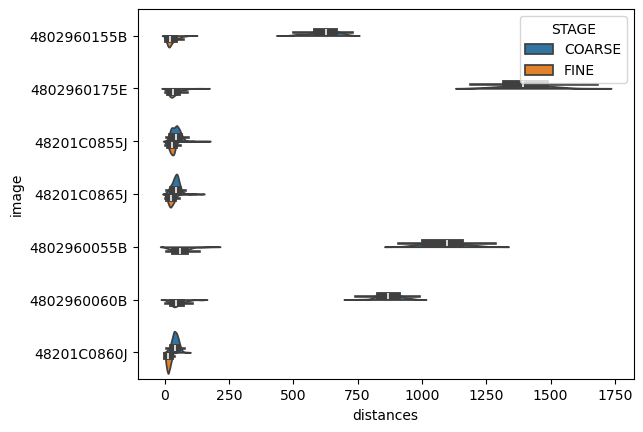

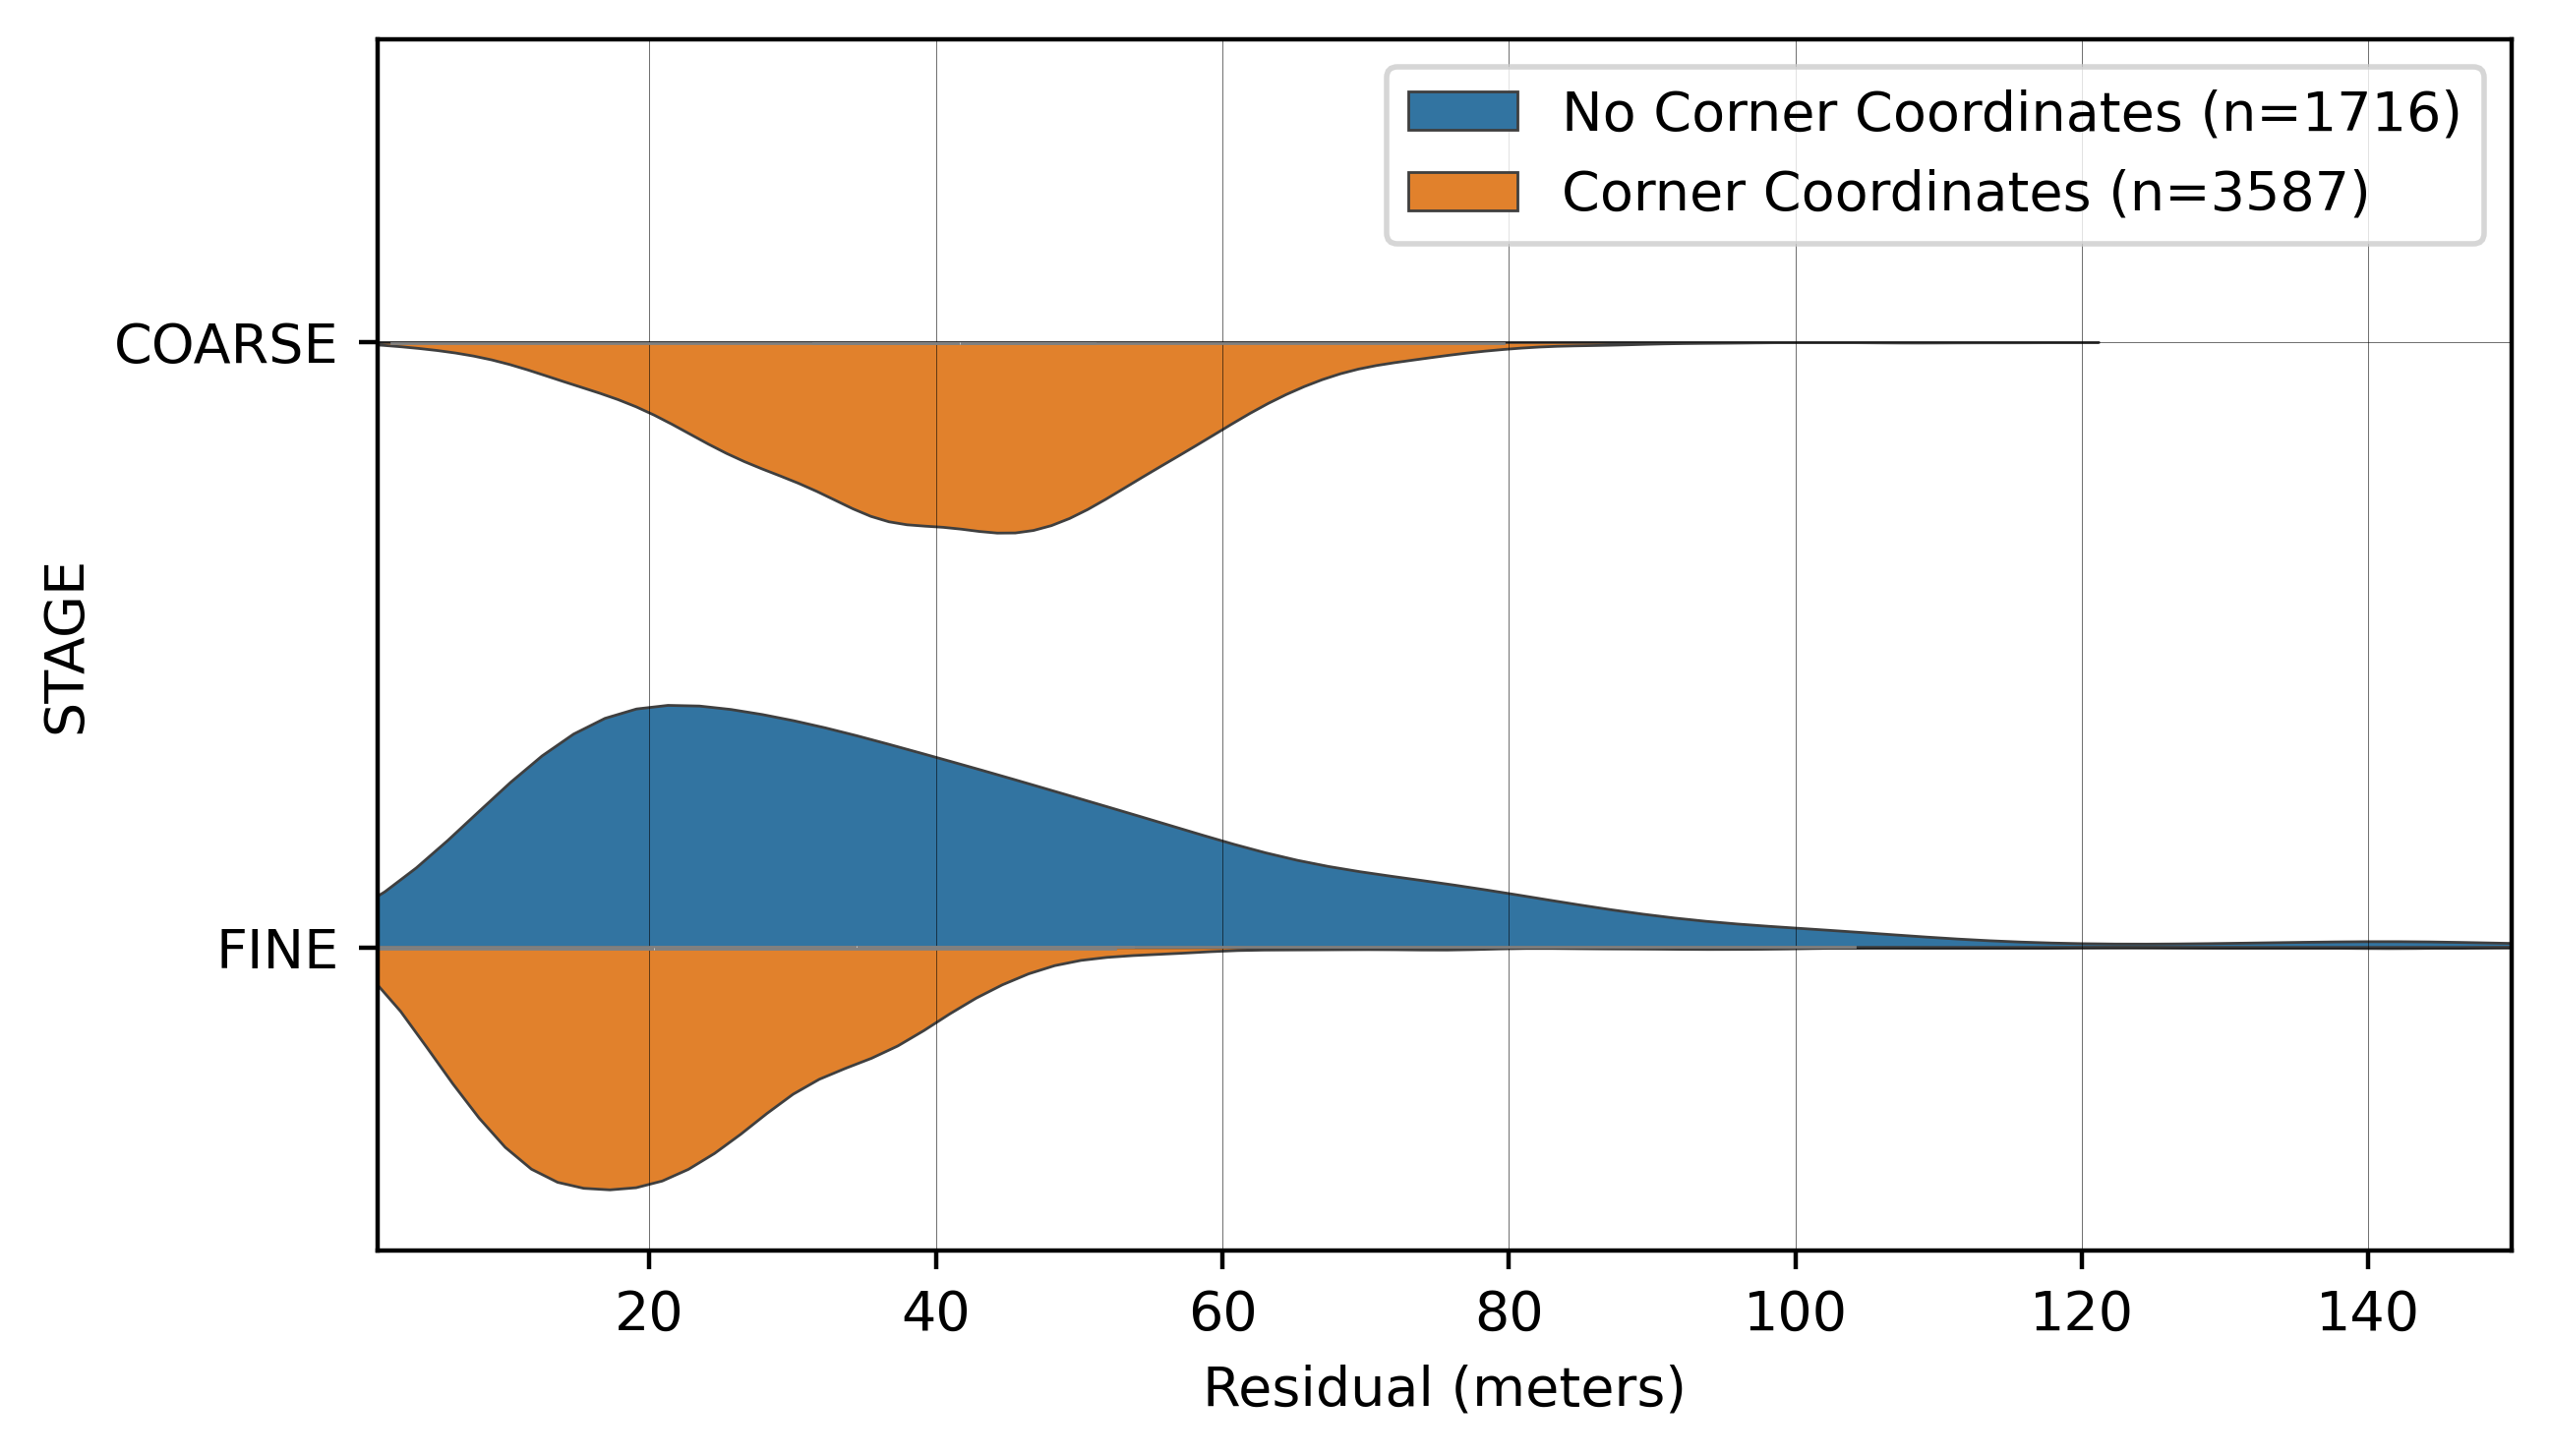

In [16]:
%matplotlib inline
fig, axs = plt.subplots(figsize=(7, 4), dpi=400)
# sns.boxplot(y='length', ax=axs, data=test[test['MATCH'] == 1])
# axs.set_yscale('log')
sns.violinplot(x='distances', y='STAGE', hue='METHOD', split=True, ax=axs, data=myresults[myresults['MATCH'] == 1], inner='box', 
               linewidth=0.5, inner_kws=dict(box_width=0.5, whis_width=0.5, color="0.5"))

axs.set_xlabel("Residual (meters)")

# axs.set_xscale('log')
# axs.set_xlim((1, 2000))
axs.set_xlim((1, 150))

# new_labels = [f'Iterative Registration', 'Corner Coordinate Digitization']  # however many hue categories you have
# handles, labels = axs.get_legend_handles_labels()
# axs.legend(handles=handles, labels=new_labels, title="", loc="upper right")

# Get counts per method
filtered = myresults[myresults['MATCH'] == 1]
filtered = filtered[filtered['STAGE'] == 'COARSE']
method_counts = filtered['METHOD'].value_counts()

# Define new_labels dynamically
label_mapping = {
    'STREETREGISTRATION'         : 'No Corner Coordinates',
    'CORNERCOORDINATES'          : 'Corner Coordinates',
}
new_labels = [f"{label_mapping[m]} (n={method_counts[m]})" for m in method_counts.index[::-1]]
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles=handles, labels=new_labels, title="", loc="upper right")


axs.grid(color='black', linewidth=0.1)

[0, 1]


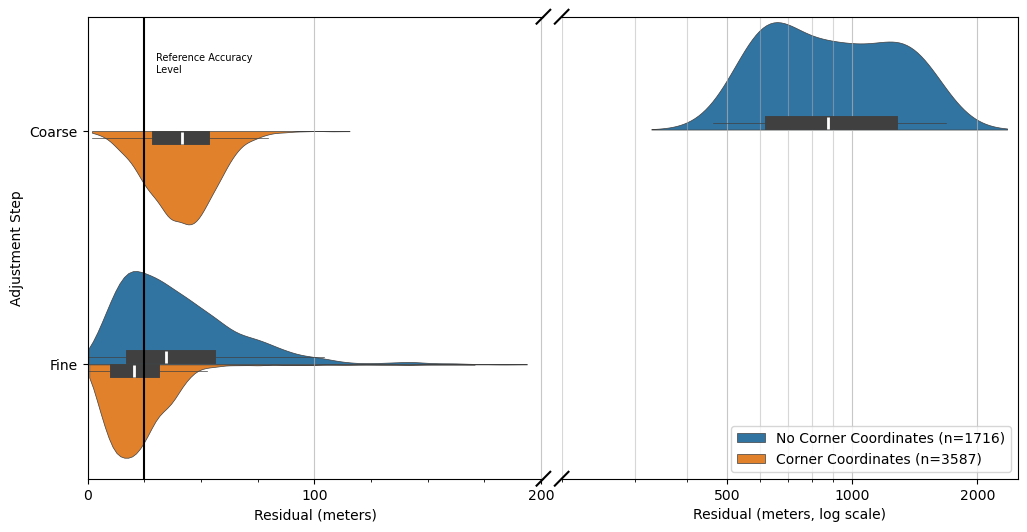

In [17]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.04, 'width_ratios' : (1, 1)}
)

sns.violinplot(
    x='distances', y='STAGE', hue='METHOD', split=True, ax=ax1,
    data=myresults[(myresults['MATCH'] == 1)], cut=0,
    inner='box', linewidth=0.5, inner_kws=dict(box_width=10, whis_width=0.5, color="0.25"), 
    legend=False, density_norm='width', bw=0.2,
)
ax1.set_xlim(0.1, 200)
ax1.set_xlabel("Residual (meters)")
ax1.spines['right'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)



# Plot high range (outlier, log scale)
sns.violinplot(
    x='distances', y='STAGE', hue='METHOD', split=True, ax=ax2,
    data=myresults[(myresults['MATCH'] == 1) & (myresults['distances'] >= 200)], log_scale=10,
    inner='box', linewidth=0.5, inner_kws=dict(box_width=10, whis_width=0.5, color="0.25"),
    density_norm='width', bw=0.5, 
)
ax2.set_xscale('log')
ax2.set_xlim(200, 2500)
ax2.set_xlabel("Residual (meters, log scale)")
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([1-d, 1+d], [-d, +d], **kwargs)        # top-right diagonal
ax1.plot([1-d, 1+d], [1-d, 1+d], **kwargs)      # bottom-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [-d, +d], **kwargs)          # top-left diagonal
ax2.plot([-d, +d], [1-d, 1+d], **kwargs)        # bottom-left diagonal

# GRID

ax1.set_xlim((0, 201))
ax1.set_xticks(np.arange(0, 201, 100))
ax1.set_xticks(np.arange(0, 201, 25), minor=True)
# ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.7, axis='x')

# ax2.set_xticks(np.arange(200, 2501, 100), minor=True)
ax2.set_xticks([500, 1000, 2000])
ax2.set_xticklabels([500, 1000, 2000])

ax1.set_ylabel("Adjustment Step")
ax1.set_yticklabels(['Coarse', 'Fine'])

ax2.set_yticks([])
# ax2.set_ylim((0, 4))
ax2.set_yticks([0, 1, 2, 3], minor=True)
ax2.set_yticklabels([])

ax2.grid(axis='x', which='minor', alpha=0.5)
ax2.grid(which='major', alpha=0.7)
ax2.set_ylabel('')

from matplotlib.ticker import NullLocator
ax2.yaxis.set_minor_locator(NullLocator())

ax1.axvline(25, color='black')

ax1.text(30, -0.25, "Reference Accuracy\nLevel", size=7)

print(ax1.get_yticks())



# LEGEND

# Get counts per method
filtered = myresults[myresults['MATCH'] == 1]
filtered = filtered[filtered['STAGE'] == 'COARSE']
method_counts = filtered['METHOD'].value_counts()

# Define new_labels dynamically
label_mapping = {
    'STREETREGISTRATION'         : 'No Corner Coordinates',
    'CORNERCOORDINATES'          : 'Corner Coordinates',
}
new_labels = [f"{label_mapping[m]} (n={method_counts[m]})" for m in method_counts.index[::-1]]
handles, labels = axs.get_legend_handles_labels()
ax2.legend(handles=handles, labels=new_labels, title="", loc="lower right")

In [18]:
cases = [('STREETREGISTRATION', 'COARSE'), 
         ('CORNERCOORDINATES', 'COARSE'),
         ('STREETREGISTRATION', 'FINE'),
         ('CORNERCOORDINATES', 'FINE')]

for i in cases:
    test_data = myresults[  (myresults['METHOD'] == i[0]) & 
                        (myresults['STAGE'] == i[1]) & 
                        (myresults['MATCH'] == 1)]['distances']
    prev_shape = test_data.shape[0]
    test_data = test_data.dropna()
    lower, upper = test_data.quantile([0.025, 0.975])
    stat, p = stats.normaltest(test_data)
    mystring = i[0] + " " + i[1]
    print(f"{mystring.ljust(25)}| Mean: {test_data.mean():.5e}\t Median: {test_data.median():.5e}\tInterval: [{lower:.3f}, {upper:.3f}]\t K² = {stat:.1f} \tp = {p:.3e}")

NameError: name 'stats' is not defined

In [19]:
test_data = myresults[(myresults['MATCH'] == 1) & (myresults['STAGE'] == 'FINE')]['distances']
print(np.median(test_data))

23.12074834533599


In [20]:
test_data = myresults[(myresults['METHOD'] == 'STREETREGISTRATION')]
print(test_data[test_data['MATCH'] == 1].shape[0], test_data.shape[0])

3432 6344


In [21]:
test_data = myresults[(myresults['METHOD'] == 'CORNERCOORDINATES')]
print(test_data[test_data['MATCH'] == 1].shape[0], test_data.shape[0])

7174 10226


In [22]:
to_manual_again = myresults[(myresults['STAGE'] == 'FINE')]

In [23]:
gpd.GeoDataFrame(to_manual_again).to_file(r'C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\Validation\testManualRevalidation.gpkg')